In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

In [2]:
# jedi 0.14.1 tab completion fails; will be fixed in 0.14.2
import jedi
if jedi.__version__ == '0.14.1':
    %config Completer.use_jedi = False
    
# Progress bar
from tqdm.auto import trange, tqdm

In [3]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S, source_spectrum

pynrc.setup_logging('WARNING', verbose=False)

In [4]:
# Observation Definitions
from pynrc.nb_funcs import make_key, obs_wfe, obs_optimize
from pynrc.nb_funcs import model_info, disk_rim_model

# Functions to run a series of operations
from pynrc.nb_funcs import do_opt, do_contrast, do_gen_hdus, do_sat_levels

# Plotting routines
from pynrc.nb_funcs import plot_contrasts, plot_contrasts_mjup, planet_mags, plot_planet_patches
from pynrc.nb_funcs import update_yscale, do_plot_contrasts, do_plot_contrasts2
from pynrc.nb_funcs import plot_hdulist, plot_images, plot_images_swlw

## Define Sources and their Reference PSF Stars

In [5]:
# Various Bandpasses
bp_v = S.ObsBandpass('v')
bp_k = pynrc.bp_2mass('k')
bp_w1 = pynrc.bp_wise('w1')
bp_w2 = pynrc.bp_wise('w2')

In [6]:
#                source,      dist, age, sptype,  vmag kmag  W1   W2
args_sources = [('PDS 70',     113, 5.4, 'K7IV',  12.2, 8.8, 8.0, 7.7)]

ref_sources = args_sources

In [7]:
# Directory housing VOTables 
# http://vizier.u-strasbg.fr/vizier/sed/
votdir = 'votables/'

# Directory to save plots and figures
outdir  = 'YSOs/'

In [8]:
# List of filters
args_filter = [('F187N',       None,       None),
               ('F200W',       None,       None),
               ('F405N',       None,       None),
               ('F410M',       None,       None),]

filt_keys = []
for filt,mask,pupil in args_filter:
    filt_keys.append(make_key(filt, mask=mask, pupil=pupil)) 

In [9]:
# Save generated figures?
save_figs = True

## SED Fit

In [10]:
# Fit spectrum to SED photometry
i=0
name_sci, dist_sci, age_sci, spt_sci, vmag_sci, kmag_sci, w1_sci, w2_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

mag_sci, bp_sci = vmag_sci, bp_v
args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
src = source_spectrum(*args)

src.fit_SED(use_err=False, robust=False, wlim=[1,10], IR_excess=True)

# Final source spectrum
sp_sci = src.sp_model

[2.73204227e-08 1.02381242e+07 3.54854907e+00]


In [11]:
# Do the same for the reference source
name_ref, spt_ref, sp_ref = name_sci, spt_sci, sp_sci

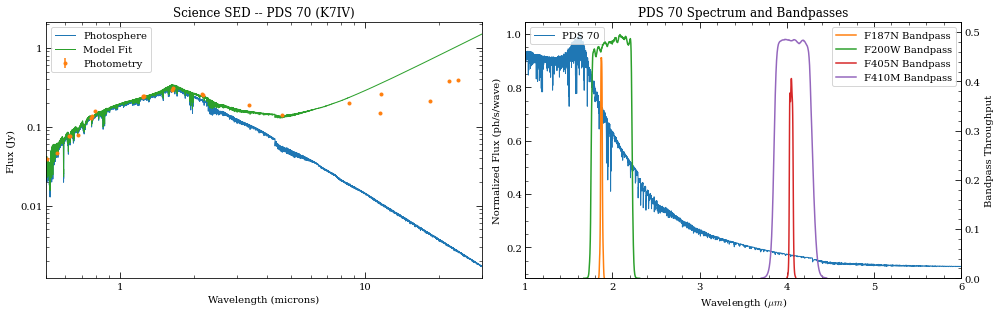

In [12]:
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot spectra 
fig, axes = plt.subplots(1,2, figsize=(14,4.5))

ax = axes[0]
src.plot_SED(ax=axes[0], xr=[0.5,30])
ax.set_title('Science SED -- {} ({})'.format(name_sci, spt_sci))
# ax.set_xscale('linear')
# ax.xaxis.set_minor_locator(AutoMinorLocator())


ax = axes[1]
xr = [1,6]

bp = pynrc.read_filter(*args_filter[-1])
sp = sp_sci
w = sp.wave / 1e4
o = S.Observation(sp, bp, binset=bp.wave)
sp.convert('photlam')
f = sp.flux / sp.flux[(w>xr[0]) & (w<xr[1])].max()

ind = (w>=xr[0]) & (w<=xr[1])
ax.plot(w[ind], f[ind], lw=1, label=sp.name)
ax.set_ylabel('Normalized Flux (ph/s/wave)')
sp.convert('flam')

ax.set_xlim(xr)
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_title('{} Spectrum and Bandpasses'.format(sp_sci.name))

# Overplot Filter Bandpass
ax2 = ax.twinx()
for i, af in enumerate(args_filter):
    bp = pynrc.read_filter(*af)
    ax2.plot(bp.wave/1e4, bp.throughput, color=cols[i+1], label=bp.name+' Bandpass')
ax2.set_ylim([0,ax2.get_ylim()[1]])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
if save_figs:
    fig.savefig(outdir+'{}_SED.pdf'.format(name_sci.replace(' ','')))


### Generate observations

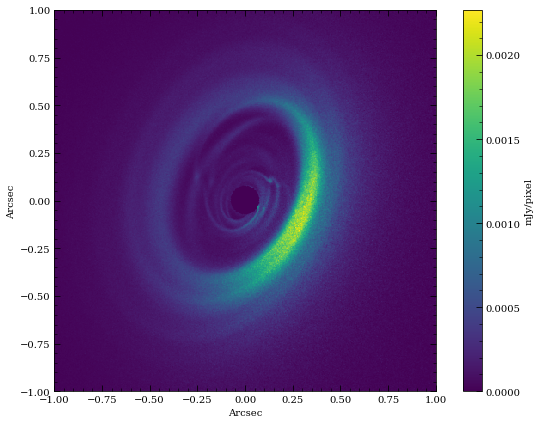

In [13]:
from astropy.io import fits
hdul = fits.open(outdir + 'model_PDS70.fits')

# Data is in million Jy per Steradian
data = hdul[0].data
data_wave = 1.6 # micons
pa_offset = 295

# Arcsec/pixel
pix_asec = 0.0045

# Steradians to square arcsec
sr_to_asec2 = (3600*180/np.pi)**2

# Data in Jy/arcsec^2
data *= (1e9 * pix_asec**2 / sr_to_asec2) # mJy / pixel

# Mask inner disk region
rho = nrc_utils.dist_image(data, pixscale=pix_asec)
data[rho<=0.075] = 0
 
hdul[0].data = nrc_utils.rotate_offset(data, pa_offset, reshape=False)

# args_disk = (hdul, pix_asec, dist_sci, data_wave, 'mJy/pixel')
# #hdul_out = pynrc.obs_nircam.model_to_hdulist(args_disk, sp_sci, bp)

# extent = np.array([-1,1,-1,1]) * hdul[0].data.shape[0] * pix_asec / 2
# plt.imshow(hdul[0].data, extent=extent)
# plt.xlim([-1,1])
# plt.ylim([-1,1])


units = 'mJy/pixel'
args_disk = (hdul, pix_asec, dist_sci, data_wave, units)
#hdul_out = pynrc.obs_nircam.model_to_hdulist(args_disk, sp_sci, bp)

extent = np.array([-1,1,-1,1]) * hdul[0].data.shape[0] * pix_asec / 2
vmax = hdul[0].data.max()
vmin = vmax/1e5
norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(1,1)
im = ax.imshow(hdul[0].data, extent=extent)#, norm=norm)
fig.colorbar(im, ax=ax, label=units)#, extend='max')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_xlabel('Arcsec')
ax.set_ylabel('Arcsec')

fig.tight_layout()


In [14]:
subsize = 160

# Create a dictionary that holds the obs_hci class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, args_disk=args_disk, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F187N_none_none
F200W_none_none
F405N_none_none
F410M_none_none


In [15]:
# if there's a disk input, then we want to remove disk 
# contributions from stellar flux and recompute to make 
# sure total flux counts matches what we computed for 
# sp_sci in previous section to match real photometry
if args_disk is not None:
    for key in filt_keys:
        obs = obs_dict[key]
        
        star_flux = obs.star_flux(sp=sp_sci) # Pass original input spectrum
        disk_flux = obs.disk_hdulist[0].data.sum()
        obs.sp_sci = sp_sci * (1 - disk_flux / star_flux)
        obs.sp_sci.name = sp_sci.name

        print(disk_flux, star_flux, obs.star_flux())

        obs.sp_ref = obs.sp_sci

96187.52959780605 613300.0941700127 517112.5645722067
1775470.3424517107 11511709.220649265 9736238.878197554
38366.01845970893 278969.2982837199 240603.27982401103
461298.81916607864 2976399.9717564746 2515101.1525903963


In [16]:
# Update detector readout
for i, key in enumerate(filt_keys):
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',10,480,480)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,20,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,15,15)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
    print(key)
    print(obs.multiaccum_times)
    _ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
    print('')

F187N_none_none
{'t_frame': 0.27864, 't_group': 0.27864, 't_int': 2.7864, 't_exp': 1337.472, 't_acq': 1473.696, 't_int_tot1': 3.0702, 't_int_tot2': 3.0702}
Point Source Sensitivity (5-sigma): 20.74 vegamag
Surface Brightness Sensitivity (5-sigma): 17.14 vegamag/arcsec^2

F200W_none_none
{'t_frame': 0.27864, 't_group': 0.27864, 't_int': 2.7864, 't_exp': 1337.472, 't_acq': 1473.696, 't_int_tot1': 3.0702, 't_int_tot2': 3.0702}
Point Source Sensitivity (5-sigma): 23.91 vegamag
Surface Brightness Sensitivity (5-sigma): 20.33 vegamag/arcsec^2

F405N_none_none
{'t_frame': 0.27864, 't_group': 0.27864, 't_int': 2.7864, 't_exp': 1337.472, 't_acq': 1473.696, 't_int_tot1': 3.0702, 't_int_tot2': 3.0702}
Point Source Sensitivity (5-sigma): 19.35 vegamag
Surface Brightness Sensitivity (5-sigma): 17.19 vegamag/arcsec^2

F410M_none_none
{'t_frame': 0.27864, 't_group': 0.27864, 't_int': 2.7864, 't_exp': 1337.472, 't_acq': 1473.696, 't_int_tot1': 3.0702, 't_int_tot2': 3.0702}
Point Source Sensitivity (5-

### Saturation 

In [17]:
sat_dict = {}

for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    sat_dict[k] = dsat_asec



F187N_none_none
Sci: PDS 70
  0 saturated pixel at NGROUP=2; Max Well: 0.35
  5 saturated pixel at NGROUP=10; Max Well: 1.75
  Sat Dist NG=2: 0.00 arcsec
Ref: PDS 70
  0 saturated pixel at NGROUP=2; Max Well: 0.35
  5 saturated pixel at NGROUP=10; Max Well: 1.75

F200W_none_none
Sci: PDS 70
  9 saturated pixel at NGROUP=2; Max Well: 6.10
  40 saturated pixel at NGROUP=10; Max Well: 30.52
  Sat Dist NG=2: 0.04 arcsec
Ref: PDS 70
  9 saturated pixel at NGROUP=2; Max Well: 6.10
  40 saturated pixel at NGROUP=10; Max Well: 30.52

F405N_none_none
Sci: PDS 70
  0 saturated pixel at NGROUP=2; Max Well: 0.22
  1 saturated pixel at NGROUP=10; Max Well: 1.08
  Sat Dist NG=2: 0.00 arcsec
Ref: PDS 70
  0 saturated pixel at NGROUP=2; Max Well: 0.22
  1 saturated pixel at NGROUP=10; Max Well: 1.08

F410M_none_none
Sci: PDS 70
  5 saturated pixel at NGROUP=2; Max Well: 2.23
  11 saturated pixel at NGROUP=10; Max Well: 11.17
  Sat Dist NG=2: 0.06 arcsec
Ref: PDS 70
  5 saturated pixel at NGROUP=2; Ma

### Roll Subtraction Curves

In [18]:
# Determine contrast curves for various WFE drift values
wfe_list = [0, 2, 5]

nsig = 5
roll = 10

# fk_contrast = ['F444W_none_none', 'F410M_none_none']
curves_dict = do_contrast(obs_dict, wfe_list, filt_keys,
                          nsig=nsig, roll_angle=roll, opt_diff=False, no_ref=True)

In [19]:
print('Filter  mag1  (SNR1)   mag2  (SNR2)')
for i, k in enumerate(filt_keys):
    obs = obs_dict[k]
    pl1_mag = [17.5, 16.5, 14.3, 14.3]
    pl2_mag = [18.5, 17.3, 14.0, 14.0]
    d1 = 0.18
    d2 = 0.25
    sp_planet1 = pynrc.stellar_spectrum('M4V', pl1_mag[i], 'vegamag', obs.bandpass)
    sp_planet2 = pynrc.stellar_spectrum('M4V', pl2_mag[i], 'vegamag', obs.bandpass)
    
    synth_obs1 = S.Observation(sp_planet1, obs.bandpass, binset=obs.bandpass.wave)
    synth_obs2 = S.Observation(sp_planet2, obs.bandpass, binset=obs.bandpass.wave)
    mag1 = synth_obs1.effstim('vegamag')
    mag2 = synth_obs2.effstim('vegamag')
    
    ind_wfe = np.where(np.array(wfe_list)==2)[0][0]
    rr, contrast, mag_sens = curves_dict[k][ind_wfe]
    # Calculate 1-sigma sensitivity at planet position
    mag1_sig = np.interp(d1, rr, mag_sens) + 2.5*np.log10(nsig)
    mag2_sig = np.interp(d2, rr, mag_sens) + 2.5*np.log10(nsig)
    snr1 = 10**((mag1_sig-mag1)/2.5)
    snr2 = 10**((mag2_sig-mag2)/2.5)
    
    print(obs.filter, f'  {mag1:.1f}  ({snr1:4.1f})   {mag2:.1f}  ({snr2:4.1f})')


Filter  mag1  (SNR1)   mag2  (SNR2)
F187N   17.5  ( 3.2)   18.5  ( 3.8)
F200W   16.5  ( 8.7)   17.3  (13.2)
F405N   14.3  (13.0)   14.0  (28.0)
F410M   14.3  (14.5)   14.0  (34.3)


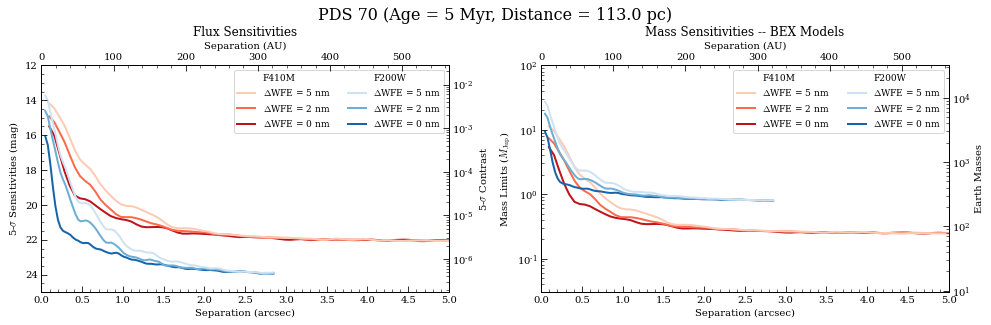

In [20]:
lin_vals = np.linspace(0.2,0.8,len(wfe_list))
c1 = plt.cm.Reds_r(lin_vals)
c2 = plt.cm.Blues_r(lin_vals)

key1, key2 = ('F410M_none_none', 'F200W_none_none')
lab1 = '{}'.format(obs_dict[key1].filter)
lab2 = '' if key2 is None else '{}'.format(obs_dict[key2].filter)
fig, axes_all = do_plot_contrasts2(key1, key2, curves_dict, nsig, obs_dict, wfe_list, age_sci,
                                   sat_dict=sat_dict, label1=lab1, label2=lab2, c1=c1, c2=c2, 
                                   xr=[0,5], yr=[25,12], yscale2='log', yr2=[3e-2, 100],
                                   planet_patches=False)

fig.subplots_adjust(top=0.8, bottom=0.1 , left=0.05, right=0.95)
fname = "{}_contrast_compare_GO.pdf".format(name_sci.replace(" ", ""))
if save_figs:
    fig.savefig(outdir+fname)

### Images

In [21]:
# Planet b:
#   K = 8.7 + 8.0 = 16.7
#   L = 8.2 + 6.9 = 15.1
# Planet c:
#   K = 8.7 + 8.8 = 17.5
#   L = 8.2 + 6.6 = 14.8

# Add known planets
dL_arr  = np.array([6.9, 6.6]) # L-Band mag contrast
Lbp     = pynrc.read_filter('F360M') # Approx L-Band
rth_arr = [(0.18,150), (0.25,280)] # sep (asec), PA
for key in filt_keys:
    obs = obs_dict[key]
    obs.kill_planets()
    
    Kobs = S.Observation(obs.sp_sci, bp_k, binset=bp_k.wave)  
    Lobs = S.Observation(obs.sp_sci, Lbp, binset=Lbp.wave)    
    Lmag_arr = Lobs.effstim('vegamag') + dL_arr
#     print(Kobs.effstim('vegamag'), Lobs.effstim('vegamag'))
#     print(Lobs.effstim('vegamag'), Lmag_arr)
    
    mass_arr = [10, 10]
    mdot_arr = [1e-8, 5e-8]
    av_arr   = [1, 10]
    for i, Lmag in enumerate(Lmag_arr):
        obs.add_planet(rtheta=rth_arr[i], runits='asec', age=5, mass=mass_arr[i], entropy=9, 
                       accr=True, mdot=mdot_arr[i], Av=av_arr[i],
                       renorm_args=(Lmag,'vegamag',Lbp))
        
    pl_mags = []
    for pl in obs.planets:
        sp = obs.planet_spec(**pl)
        renorm_args = pl['renorm_args']
        sp_norm = sp.renorm(*renorm_args)
        sp_norm.name = sp.name
        sp = sp_norm

        o = S.Observation(sp, obs.bandpass, binset=obs.bandpass.wave)
        pl_mags.append(o.effstim('vegamag'))
        
    print('Planet Mags:', key, pl_mags)
  

Planet Mags: F187N_none_none [17.558813267583748, 18.494508127112056]
Planet Mags: F200W_none_none [16.492546568604215, 17.258345882154323]
Planet Mags: F405N_none_none [14.243104497667163, 13.90058045641738]
Planet Mags: F410M_none_none [14.278017121001367, 13.912911115576765]


In [22]:
# Ideal
wfe_ref = 0
wfe_roll = 0
hdul_dict_ideal = do_gen_hdus(obs_dict, filt_keys, wfe_ref, wfe_roll, no_ref=False, opt_diff=False,
                              oversample=4, PA1=0, PA2=0, exclude_noise=True)


In [44]:
# Roll Subtracted
wfe_ref = 0
wfe_roll = 1
hdul_dict = do_gen_hdus(obs_dict, filt_keys, wfe_ref, wfe_roll, no_ref=True, opt_diff=False,
                        oversample=4, PA1=-5, PA2=5)

In [24]:
fk_images = [
    'F187N_none_none',
    'F200W_none_none',
    'F405N_none_none',
    'F410M_none_none',
]

fk_images = filt_keys

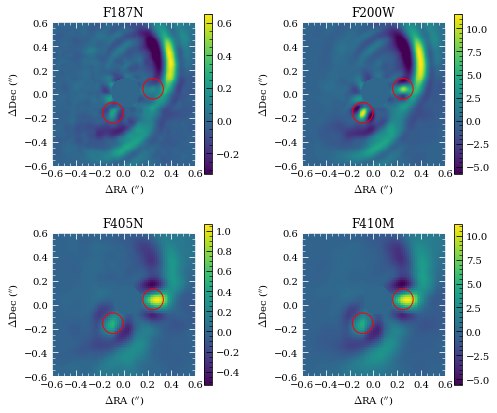

In [48]:
fig, axes = plt.subplots(2,2, figsize=(7,6))

xylim = 0.6
xr = yr = np.array([-1,1])*xylim

for i, k in enumerate(fk_images):
    ax = axes.flatten()[i]
    hdul = deepcopy(hdul_dict[k])
    
    # Saturation radius
    sat_rad = sat_dict[k]
    
    # Mask out inner region
    mask_rad = np.max([sat_rad, 0.12])

    rho = nrc_utils.dist_image(hdul[0].data, pixscale=hdul[0].header['PIXELSCL'])
    vmax = np.nanmax(hdul[0].data[(rho>mask_rad) & (rho<xylim)])
    hdul[0].data[rho<=mask_rad] = 0

    plot_hdulist(hdul, ax=ax, xr=xr, yr=yr, vmin=-vmax/2, vmax=vmax, cb_label='')
    ax.set_title('{}'.format(obs_dict[k].filter))
    ax.set_xlabel('$\Delta$RA ($^{\prime\prime}$)')
    ax.set_ylabel('$\Delta$Dec ($^{\prime\prime}$)')
    #ax.set_title('Roll Sub (' + '$\Delta$' + 'WFE = {} nm)'.format(wfe_roll))


for pl in obs.planets:
    loc = (np.array(pl['xyoff_pix'])) * obs.pix_scale
    for ax in axes.flatten():
        circle = matplotlib.patches.Circle(loc, radius=xylim/7., lw=1, edgecolor='red', facecolor='none')
        ax.add_artist(circle);

fig.tight_layout()

fname = "{}_images_GO.pdf".format(name_sci.replace(" ", ""))
fig.savefig(outdir+fname)

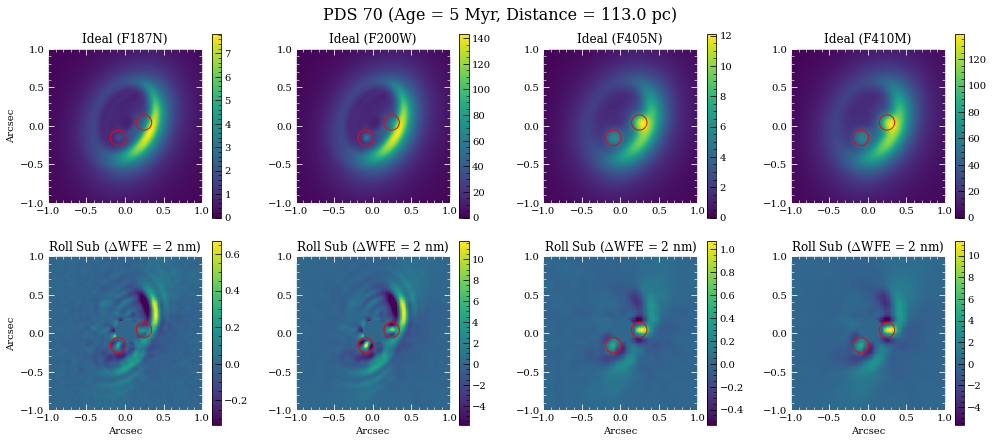

In [25]:
from copy import deepcopy
fig, axes_arr = plt.subplots(2,4, figsize=(14,6.3))

xylim = 1.0
xr = yr = np.array([-1,1])*xylim

axes = axes_arr[0]
for i, k in enumerate(fk_images):
    ax = axes[i]
    hdul = hdul_dict_ideal[k]

    vmax = np.nanmax(hdul[0].data)
    plot_hdulist(hdul, ax=ax, xr=xr, yr=yr, vmax=vmax, interpolation='bicubic', cb_label='')
    ax.set_title('Ideal ({})'.format(obs_dict[k].filter))

axes = axes_arr[1]
for i, k in enumerate(fk_images):
    ax = axes[i]
    hdul = deepcopy(hdul_dict[k])
    
    # Saturation radius
    sat_rad = sat_dict[k]
    
    # Mask out inner region
    mask_rad = np.max([sat_rad, 0.15])

    rho = nrc_utils.dist_image(hdul[0].data, pixscale=hdul[0].header['PIXELSCL'])
    vmax = np.nanmax(hdul[0].data[(rho>mask_rad) & (rho<xylim)])
    hdul[0].data[rho<=mask_rad] = 0

    plot_hdulist(hdul, ax=ax, xr=xr, yr=yr, vmin=-vmax/2, vmax=vmax, cb_label='')
    ax.set_title('Roll Sub (' + '$\Delta$' + 'WFE = {} nm)'.format(wfe_roll))
    

# Location of planet
for pl in obs.planets:
    loc = (np.array(pl['xyoff_pix'])) * obs.pix_scale
    for ax in axes_arr.flatten():
        circle = matplotlib.patches.Circle(loc, radius=xylim/10., lw=1, edgecolor='red', facecolor='none')
        ax.add_artist(circle);
        
for axes in axes_arr:
    for i, ax in enumerate(axes):
        if i>0: ax.set_ylabel('')
for ax in axes_arr[0]:
    ax.set_xlabel('')
            

# Title
dist = obs.distance
age_str = 'Age = {:.0f} Myr'.format(age_sci)
dist_str = 'Distance = {:.1f} pc'.format(dist)
title_str = '{} ({}, {})'.format(name_sci,age_str,dist_str)

fig.suptitle(title_str, fontsize=16);

fig.tight_layout()
fig.subplots_adjust(top=0.92)

fname = "{}_images.pdf".format(name_sci.replace(" ", ""))
# if save_figs:
#     fig.savefig(outdir+fname)